In [44]:
import os
import sys
import random

import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

## Класс для обработки и подготовки картинок

In [3]:
# pip install --q tensorflow-addons

In [99]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_paths, batch_size=16, image_size=(128, 128), augment=False):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.on_epoch_end()

    def augment(self, input_image, input_mask):
        if tf.random.uniform(()) > 0.5:
            # Random flipping of the image and mask
            input_image = tf.image.flip_left_right(input_image)
            input_mask = tf.image.flip_left_right(input_mask)

        return input_image, input_mask

    def __load__(self, id_name):
        image_path = id_name
        mask_path = None

        ## Check if the file is an image or mask
        if image_path.endswith(".jpg"):
            mask_path = os.path.splitext(image_path)[0] + ".png"
        elif image_path.endswith(".png"):
            mask_path = image_path
            image_path = os.path.splitext(image_path)[0] + ".jpg"

        ## Reading Image
        image = cv2.imread(image_path, 1) # different colors for mask!
        image = cv2.resize(image, self.image_size)

        mask = np.zeros((self.image_size[0], self.image_size[1]))

        ## Reading Mask
        if mask_path is not None:
            mask_image = cv2.imread(mask_path, 0)
            mask_image = cv2.resize(mask_image, self.image_size)
            mask = mask_image

        ## Normalizing
        image = image / 255.
        mask = mask / 255.

        if self.augment:
            input_image, input_mask = self.augment(image, mask)
            image = input_image
            mask = input_mask

        return image, mask[..., np.newaxis]


    def __getitem__(self, index):
        """
        Here, we loop through each image in the batch and generate 50 augmented images with masks
        by calling __load__() multiple times, and then append them to the image and mask arrays.
        With this modification, the DataGen class will generate 50 * len(self.image_paths)
        images and masks for training, effectively increasing the size of the dataset.

        """
        if(index+1)*self.batch_size > len(self.image_paths):
            self.batch_size = len(self.image_paths) - index*self.batch_size

        image_batch = self.image_paths[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for i in range(len(image_batch)):
            for j in range(20):
                _img, _mask = self.__load__(image_batch[i])
                image.append(_img)
                mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask


    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))

In [100]:
image_size = (128, 128)
epochs = 5
batch_size = 16

CLASSES = 8

In [101]:
train_path = os.path.abspath("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train")
print(os.listdir(train_path))

['cmp_b0001.jpg', 'cmp_b0001.png', 'cmp_b0002.jpg', 'cmp_b0002.png', 'cmp_b0003.jpg', 'cmp_b0003.png', 'cmp_b0004.jpg', 'cmp_b0004.png', 'cmp_b0005.jpg', 'cmp_b0005.png', 'cmp_b0006.jpg', 'cmp_b0006.png', 'cmp_b0007.jpg', 'cmp_b0007.png', 'cmp_b0008.jpg', 'cmp_b0008.png', 'cmp_b0009.jpg', 'cmp_b0009.png', 'cmp_b0010.jpg', 'cmp_b0010.png', 'cmp_b0011.jpg', 'cmp_b0011.png', 'cmp_b0012.jpg', 'cmp_b0012.png', 'cmp_b0013.jpg', 'cmp_b0013.png', 'cmp_b0014.jpg', 'cmp_b0014.png', 'cmp_b0015.jpg', 'cmp_b0015.png', 'cmp_b0016.jpg', 'cmp_b0016.png', 'cmp_b0017.jpg', 'cmp_b0017.png', 'cmp_b0018.jpg', 'cmp_b0018.png', 'cmp_b0019.jpg', 'cmp_b0019.png', 'cmp_b0020.jpg', 'cmp_b0020.png', 'cmp_b0021.jpg', 'cmp_b0021.png', 'cmp_b0022.jpg', 'cmp_b0022.png', 'cmp_b0023.jpg', 'cmp_b0023.png', 'cmp_b0024.jpg', 'cmp_b0024.png', 'cmp_b0025.jpg', 'cmp_b0025.png', 'cmp_b0026.jpg', 'cmp_b0026.png', 'cmp_b0027.jpg', 'cmp_b0027.png', 'cmp_b0028.jpg', 'cmp_b0028.png', 'cmp_b0029.jpg', 'cmp_b0029.png', 'cmp_b0030.jp

In [102]:
# Get list of image file paths in train path
train_ids = sorted([os.path.join(train_path, filename)
                    for filename in os.listdir(train_path)
                    if filename.endswith('.jpg') or filename.endswith('.png')])
print(train_ids[:5])

['C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0001.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0001.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0002.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0002.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0003.jpg']


In [103]:
## Validation Data Size
val_data_size = 60

train_ids = train_ids[val_data_size:]
valid_ids = train_ids[:val_data_size]

In [104]:
print(valid_ids[:5])

['C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0031.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0031.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0032.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0032.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0033.jpg']


In [105]:
len(valid_ids)

60

In [106]:
train_gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
X_train, y_train = train_gen.__getitem__(0)
print(X_train.shape, y_train.shape) # output should be (16, 128, 128, 3) (16, 128, 128, 1) # ура

(320, 128, 128, 3) (320, 128, 128, 1)


In [107]:
valid_gen = DataGen(valid_ids, batch_size=batch_size, image_size=image_size)
X_valid, y_valid = valid_gen.__getitem__(0)
print(X_valid.shape, y_valid.shape) # output should be (16, 128, 128, 3) (16, 128, 128, 1) # ура

(320, 128, 128, 3) (320, 128, 128, 1)


In [108]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_train:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (320, 128, 128, 3)
y_train: (320, 128, 128, 1)

X_train: (320, 128, 128, 3)
y_valid: (320, 128, 128, 1)


Посмотрим, что получилось.

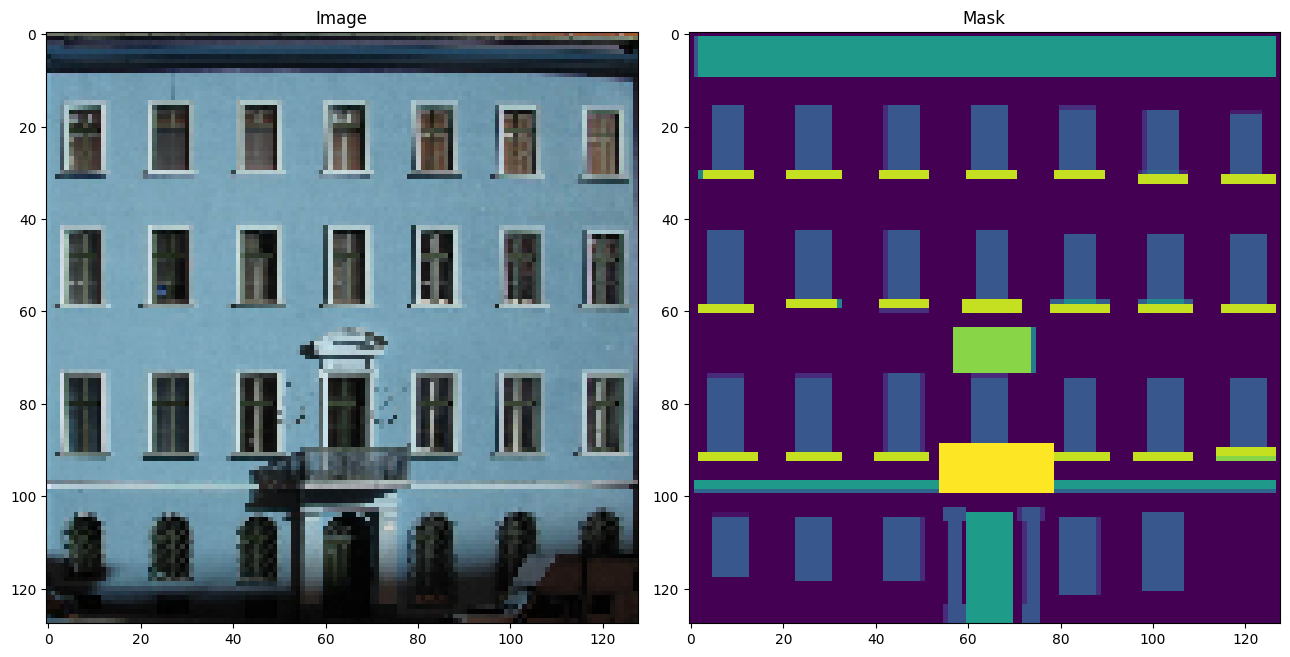

In [110]:
# выберем рандомно картинку и соответствующую ей маску
random_index = random.randint(0, len(X_train) - 1)
random_image = X_train[random_index]
random_mask = y_train[random_index]

# Display the image and its corresponding mask
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
ax[0].imshow(random_image)
ax[0].set_title('Image')
ax[1].imshow(random_mask.squeeze())
ax[1].set_title('Mask')
plt.tight_layout()
plt.show();

## Формируем простейшую архитектуру U-Net

In [111]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - (dice_coefficient(y_true, y_pred))

In [112]:
NUM_EPOCHS = 5
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VALIDATION_STEPS = len(X_valid) // BATCH_SIZE

INPUT_SHAPE = (128, 128, 3)

### Model 1

In [113]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [114]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(INPUT_SHAPE)

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="softmax")(u4)

    model = keras.models.Model(inputs, outputs)

    return model

In [115]:
model = UNet()

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=[dice_coefficient,'accuracy'])

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_166 (Conv2D)            (None, 128, 128, 16  448         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_167 (Conv2D)            (None, 128, 128, 16  2320        ['conv2d_166[0][0]']             
                                )                                                          

In [116]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))

basic_UNet = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=1,
                    epochs=5)

Epoch 1/5


### Model 2

In [92]:
def unet2(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)

    # Decoder path
    up3 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv2)
    up3 = tf.keras.layers.concatenate([up3, conv1], axis=3)
    conv3 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    conv3 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation='softmax')(conv3)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=[dice_coefficient,'accuracy'])

    return model

In [93]:
%%time

unet2 = unet2(INPUT_SHAPE)
optimizer = Adam(learning_rate=0.0001)
unet2.compile(optimizer, loss='binary_crossentropy', metrics=[dice_coefficient,'accuracy'])

steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))

unet2_model = unet2.fit_generator(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=2,
                    epochs=5)

<timed exec>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5


KeyboardInterrupt: 

### Model 3

In [94]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - (dice_coefficient(y_true, y_pred))

In [95]:
def create_unet3(input_shape):

    inputs = tf.keras.layers.Input(input_shape)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(s)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv5)

    upconv6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    upconv6 = tf.keras.layers.concatenate([upconv6, conv4])
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv6)

    upconv7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upconv7 = tf.keras.layers.concatenate([upconv7, conv3])
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv7)

    upconv8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    upconv8 = tf.keras.layers.concatenate([upconv8, conv2])
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv8)

    upconv9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    upconv9 = tf.keras.layers.concatenate([upconv9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=[dice_coefficient,'accuracy'])

    return model

In [96]:
%%time

def train_unet3(model,
                X_train, y_train,
                X_valid, y_valid,
                batch_size=None,
                epochs=5,
                steps_per_epoch=None,
                validation_steps=None):

    steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
    valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))

    train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=batch_size)
    valid_generator = ImageDataGenerator().flow(X_valid, y_valid, batch_size=batch_size)

    callbacks = [EarlyStopping(patience=6, monitor='loss')]

    model.fit_generator(train_generator,
                        validation_data=valid_generator,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        verbose=2,
                        callbacks=callbacks)

    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [97]:
unet3 = create_unet3(INPUT_SHAPE)
unet3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 128, 128, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv2d_147 (Conv2D)            (None, 128, 128, 16  448         ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

In [98]:
unet3_history = train_unet3(unet3,
                            X_train, y_train,
                            X_valid, y_train,
                            batch_size=16,
                            epochs=10)

Epoch 1/10


<timed exec>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


KeyboardInterrupt: 